In [2]:
# vanilla autoencoder, single image dataset(!) adapted from Mike X Cohen code

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from PIL import Image
import matplotlib.pyplot as plt

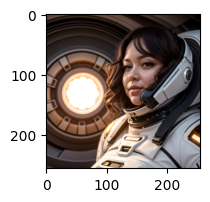

torch.Size([1, 196608])
checkpoint 2


In [5]:
# load image from the workspace directory using PIL
image = Image.open('C:/MyPythonCoding/MyDeepLearningCoding/general_images/1024x1024RGB_image_sample.png')

# rescale image with PIL
IMGSIZE=256
image_resized = image.resize((IMGSIZE, IMGSIZE))

# display the image
plt.figure(figsize=(2,2))
plt.imshow(image_resized)
plt.show()

# flatten to 1D array
image_flattened = np.array(image_resized).flatten()

# normalize the data
image_flattened = image_flattened / np.max(image_flattened)

# convert to tensor and create batch
dataT = torch.tensor(image_flattened).float().unsqueeze(0)

print(dataT.shape)
print('checkpoint 2')

In [46]:
# create a class for the model
def fn_create_AutoEncoderModel():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      self.input = nn.Linear(IMGSIZE*IMGSIZE*3,26)

      self.enc = nn.Linear(26,1)

      self.lat = nn.Linear(1,26)

      self.dec = nn.Linear(26,IMGSIZE*IMGSIZE*3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y

  # create the model instance
  net = aenet()

  lossfun = nn.MSELoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [47]:
def function2trainTheModel():
  numepochs = 400

  net,lossfun,optimizer = fn_create_AutoEncoderModel()       # create a new model
  
  losses = []     # initialize losses

  for epochi in range(numepochs):
    yHat = net(dataT)              # forward pass : pass the single image through the model
    loss = lossfun(yHat,dataT)     # loss         : compare the output to the input

    optimizer.zero_grad()          # backprop
    loss.backward()
    optimizer.step()

    # losses in this epoch
    losses.append( loss.item() )
    if epochi%50==0: print (epochi,' of ',numepochs)
  
  return losses,net

In [48]:
# TRAIN model
#############
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')


0  of  400
50  of  400
100  of  400
150  of  400
200  of  400
250  of  400
300  of  400
350  of  400
Final loss: 0.0008


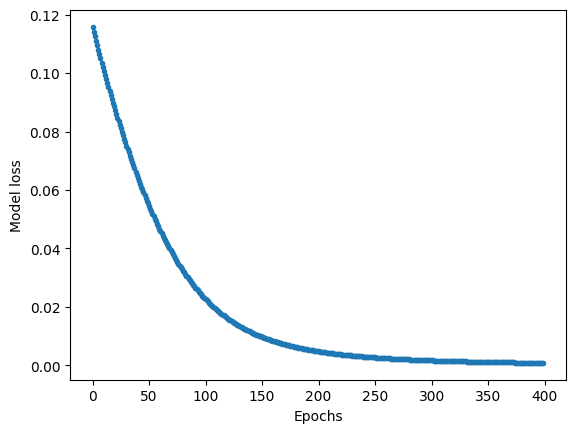

In [49]:
# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

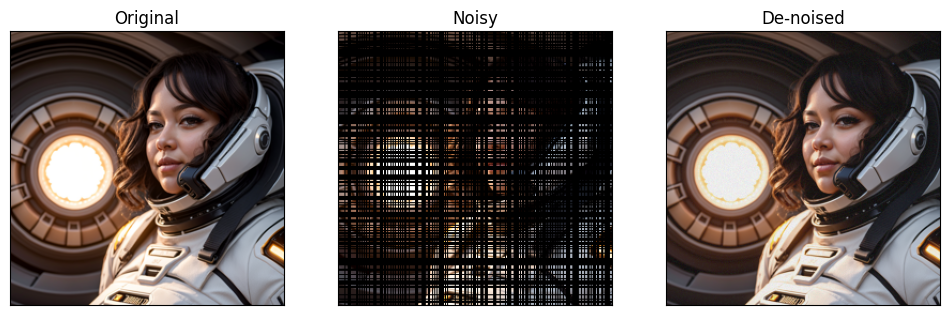

In [50]:
# create a true copy of the data
X = copy.deepcopy( dataT )

# add noise...
img = X.view(IMGSIZE,IMGSIZE,3)     # reshape the image

for lines in range(0,400):
  # occlude random rows or columns
  startloc = np.random.choice(range(2,IMGSIZE-2))
  if np.random.choice(range(0,1000))%2==0: # even -> horizontal occlusion
    #img[startloc:startloc+1,:,:] = np.random.uniform(0, 1)
    img[startloc:startloc+1,:,:] = 0 # black out the occluded part
  else:      # odd -> vertical occlusion
    #img[:,startloc:startloc+1,:] = np.random.uniform(0, 1)
    img[:,startloc:startloc+1,:] = 0 # black out the occluded part


X = img.view(1,IMGSIZE*IMGSIZE*3)    # reshape back to 1D
deOccluded = net(X)        # run this through the (TRAINED) model

# show images alongside each other
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(dataT.view(IMGSIZE, IMGSIZE, 3).detach())
axs[0].set_title('Original')
axs[0].set_xticks([]), axs[0].set_yticks([])

axs[1].imshow(X.view(IMGSIZE, IMGSIZE, 3).detach())
axs[1].set_title('Noisy')
axs[1].set_xticks([]), axs[1].set_yticks([])

axs[2].imshow(deOccluded.view(IMGSIZE, IMGSIZE, 3).detach())
axs[2].set_title('De-noised')
axs[2].set_xticks([]), axs[2].set_yticks([])
plt.show()

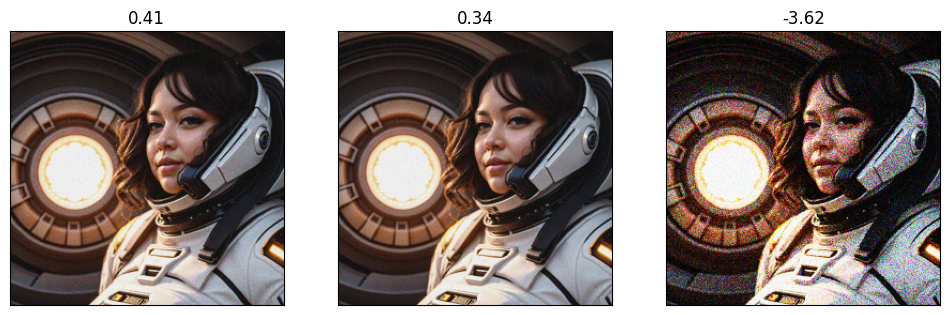

In [51]:
# create another model that just decodes the latent representation
def fnDECODER():
  class mydecoder(nn.Module):
    def __init__(self):
      super().__init__()

      self.lat = nn.Linear(1,26)

      self.dec = nn.Linear(26,IMGSIZE*IMGSIZE*3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y

  # create the model instance
  decnet = mydecoder()

  # copy the weights from the trained 'net' model to 'decnet', for both the latent and decoder layers
  decnet.lat.weight.data = net.lat.weight.data
  decnet.lat.bias.data = net.lat.bias.data

  decnet.dec.weight.data = net.dec.weight.data
  decnet.dec.bias.data = net.dec.bias.data

  return decnet

decnet = fnDECODER()
#create a tensor array of 3 latents
Lats = [np.random.randn(1) for _ in range(3)]
L = [torch.tensor(lat).float() for lat in Lats]

remade1 = decnet(L[0]) # decode the latent representations
remade2 = decnet(L[1])
remade3 = decnet(L[2])

# show images
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(remade1.view(IMGSIZE, IMGSIZE, 3).detach())
axs[0].set_xticks([]), axs[0].set_yticks([])
axs[0].set_title(round(L[0].item(),2))


axs[1].imshow(remade2.view(IMGSIZE, IMGSIZE, 3).detach())
axs[1].set_xticks([]), axs[1].set_yticks([])
axs[1].set_title(round(L[1].item(),2))

axs[2].imshow(remade3.view(IMGSIZE, IMGSIZE, 3).detach())
axs[2].set_xticks([]), axs[2].set_yticks([])
axs[2].set_title(round(L[2].item(),2))

plt.show()